# Sales and Operations Planning - Model Building
This notebook is an example of how decision optimization can help sales and operations planners to execute the most profitable supply chain strategy while balancing supply and demand. First, introduction and problem description are presented. We then provide the mathematical programming formulation. And following the data understanding and preparation details, mathematical model written in Python is presented. Finally, we conclude the notebook with discussion of results. 

This notebook requires the Commercial Edition of CPLEX engines to solve the optimization model, which is included in the default Python + DO runtime.

**Contents**

- [Introduction](#Introduction)
- [Problem-Description](#Problem-Description)
- [Formulation](#Formulation)
- [Data Preparation](#Data-Preparation)
    - [Data Input](#Data-Input)
    - [Pre-processing](#Pre-processing)
- [Decision Variables](#decision-variables)
    - [Production Plan](#Production-Plan)
    - [Product Allocation](#Product-Allocation)
    - [Sales](#Sales)
    - [Inventory](#Inventory)
- [Constraints](#Constraints)
    - [The total amount of production per month is limited by the capacity of the plant](#The-total-amount-of-production-per-month-is-limited-by-the-capacity-of-the-plant)
    - [Plants cannot produce more than their product-based capacity](#Plants-cannot-produce-more-than-their-product-based-capacity)
    - [Production equals Allocation](#Production-equals-Allocation)
    - [Executed sales are at least the firm sales](#Executed-sales-are-at-least-the-firm-sales)
    - [Executed sales are at most the planned demand](#Executed-sales-are-at-most-the-planned-demand)
    - [Inject the initial inventory to the decision variable inventory](#Inject-the-initial-inventory-to-the-decision-variable-inventory)
    - [Starting Inventory + Allocation = Executed Sales + Ending Inventory](#Starting-Inventory-+-Allocation-=-Executed-Sales-+-Ending-Inventory)
    - [Ending Inventory = Starting Inventory of the previous month (no inventory at the end of last month)](#Ending-Inventory-=-Starting-Inventory-of-the-previous-month-(no-inventory-at-the-end-of-last-month))
- [KPIs and Objectives](#KPIs-and-Objectives)
- [Model Solving](#Model-Solving)
- [Solution Handling](#Solution-Handling)
- [Solution Review](#Solution-Review)

## Introduction
Manufacturing companies, producing a wide variety of products for global  markets, must periodically provide production plans for their geographically distributed plants. Production capacity is matched up with forecasted sales demand. The critical decision is how to best allocate production among different facilities to meet worldwide market demands; and as a result high-level production plans will be generated.

Costs and service levels are two main objectives of interest in a typical supply chain. Both objectives can be better optimized by collaborative decision-making and optimization models. Lack of integration in production and distribution operations yields to substantial inefficiencies and, consequently, poor total system performance. And, many companies prefer to hold limited inventory in the supply chain. Therefore, coordinating production and distribution operations becomes more crucial for satisfying on-time delivery requirements without intermediate storage. 

In such a situation, sourcing decisions to reduce transportation costs are highly affected by production capacities and costs. Motivated by the fact that an increasing number of companies are now adopting advanced analytical models, we study the sales and operations planning problem of optimizing customer service levels and total costs in an integrated production and distribution environment. 

Because generally there are alternative production facilities with limited capacities, overall supply chain costs together with capacities and capabilities are main drivers for sales and operations planning decisions.

Unique challenges can be summarized as: 
- Fulfillment vs cost trade-offs
- Integrated production and distribution decisions
- Need to respond faster to market shifts and analyze what-if scenarios

And expected benefits include: 
- Better fulfillment
- Reduced costs
- Quick  responses to
    - Supply disruption
    - Demand fluctuations (e.g.  new promotions, popular products)


## Problem Description
The problem considered in this notebook consists of production planning of customer orders (motorcycles) distributed in different geographies (markets). There exist a number of manufacturing facilities with different capacities and capabilities. Unit production cost and unit transportation cost occur depending on the sourcing facility of the demand. Planning is performed on a monthly basis. Orders (or demand forecasts) are received by manufacturer and processed by eligible facilities. Problem can be defined as deciding on how much to produce in each month and in each facility. 

Firm sales (which are already agreed to be satisified) are also considered and the model needs to ensure that firm sales are satisfied regardless of profit. The model can decide on fully, partially or not at all satisfying the remaining demand based on profitability and available capacity. Inventory build-up (producing an order in an earlier month) is allowed but back-orders (fulfilling an order in a later month) are not allowed. The objective is to maximize total profit which is total revenue minus production and transportation costs. 

As a summary, the company manufactures motorcycles for global markets. And it has to provide monthly plans for its geographically distributed plants. This example provides a look at how this manufacturer handles their monthly planning process, in which production capacity is matched up with forecasted sales demand.

## Formulation
In this section, we formulate the problem in a mathematical way, which will help us to better understand the problem, to make decisions about how to prepare the data sets and how to construct the code in a more efficient way. 
### Notation 
**Time** The sales and production planning takes place on a monthly basis. Let $T := \bigcup\limits_{t}t$ be the set of all months. 

**Products** Let $P := \bigcup\limits_{p}p$ be the set of all products. 

**Plants** Let $L := \bigcup\limits_{l}l$ be the set of plants [*Plants*]. The function $c: L\times T \rightarrow \mathbb{N}$ expresses the capacity of a plant on a monthly level [*PlantMonthCapacities*]. For convenience, we write $c_{lt}$ as value of the function.  

**Plants-Products** Define $\Lambda$ as the set of pairs $(l, p)$, if the product $p \in P$ could be produced in the plant $l \in L$. The cost of producing a product $p \in P$ in the plant $l \in L$ is reflected on the function $r: \Lambda \rightarrow \mathbb{N}$  [*PlantProductCosts*]. Compared to the plant level capacity, there is also a capacity on the product level. Define  $\tilde{c}: \Lambda\times T \rightarrow \mathbb{N}$, which specifies the capacity on a plant-product-month level  [*PlantProductMonthCapacities*].

**Markets** Let $M := \bigcup\limits_{m}m$ be the set of markets.

**Markets-Products** We call the maximum capacity of a market "demand" in this formulation. In other words, the sales of a specific product in one market must not exceed its demand. If there is demand for product $p \in P$ in the market $m \in M$ in the month $t \in T$, then we say $(p, m, t) \in \Pi$. The function $d: \Pi \rightarrow \mathbb{N}$ defines the demand at a product-market-month level [*Demands*]. One portion of the demand is called firm sales, which refer to planned orders that can be frozen in quantity and time. Define $f: \Pi \rightarrow \mathbb{N}$ as the firm sales [*FirmSales*].
The function $e: P \times M \times T \rightarrow$ defines the sales price for a product $p \in P$, in the market $m \in M$, for the month $t \in T$ [*SalesPrice*]. Define $i: P \times M \rightarrow \mathbb{N}$, which represents the initial inventory of the product $p \in P$ in the market $m \in M$ [*InitialInventories*]. 

**Transportation Cost**  The mapping $h: \Lambda \times M \rightarrow \mathbb{N}$ represents the transportation cost of the product $p\in P$, which is produced in the plant $l, (l,p) \in \Lambda$ and is allocated to the market $m \in M$ [*Transportation*].

### Decision Variables
**Production** Let $O_{lpt}$ represent the production of the product $p \in P$ in the plant $l \in L$ for the month $t \in T$, where $(l, p) \in \Gamma$.

**Allocation** The variable $A_{lpmt}$ represents the number of units of product $p \in P$, which are produced in the plant $l \in L, (l,p) \in \Lambda$ and allocated to the market $m\in M$ in the month $t \in T$.

**Executed Sales** The variable $S_{pmt}$ maps the product $p$, the market $m$ and the month $t$ to the executed sales, where $(p, m, t) \in \Pi$. 

**Inventory** The inventory at the beginning of the month $t \in T$ for the product $p\in P$ in the market $m\in M$ is called $V_{pmt}$. The same is also defined for the end of the month, $W_{pmt}$, which only exists for result presentation purpose. 

### MIP Formulation
#### 1. The total amount of production per month is limited by the capacity of the plant.
$
\begin{equation}
\sum\limits_{p: (p,l) \in \Gamma} O_{lpt} \leq c_{lt}, \qquad \forall l \in L, t \in T.
\end{equation}
$

#### 2. Plants (for each product and month) cannot produce more than their product-based capacity.
$
\begin{equation}
O_{lpt} \leq \tilde{c}_{lpt}, \qquad \forall (l,p) \in \Lambda, t \in T.
\end{equation}
$

#### 3. Production equals allocation.
$
\begin{equation}
O_{lpt} = \sum\limits_{m\in M} A_{lpmt}, \qquad \forall (l,p) \in \Lambda, t \in T.
\end{equation}
$

#### 4. Executed Sales are at least the firm sales.
$
\begin{equation}
S_{pmt} \geq f_{pmt}, \qquad \forall (p,m,t) \in \Pi.
\end{equation}
$

#### 5. Executed Sales are at most the planned demand.
$
\begin{equation}
S_{pmt} \leq d_{pmt}, \qquad \forall (p,m,t) \in \Pi.
\end{equation}
$

#### 6. Inject the initial inventory to the first time period of the decision variable starting inventory
$
\begin{equation}
V_{pmt} = i_{pm}, \qquad \forall p \in P, m \in M, \textit{if } t=\min\{t, t\in T\}.
\end{equation}
$

#### 7. Starting Inventory + Allocation = Executed Sales + Ending Inventory.
$
\begin{equation}
V_{pmt} + \sum \limits_{l \in L: (l,p)\in \Lambda} A_{lpmt}= S_{pmt} + W_{pmt}, \qquad \forall p \in P, m \in M, t\in T.
\end{equation}
$

#### 8. Ending Inventory = Starting Inventory of the next month (no inventory at the end of last month).
$
\begin{align}
W_{pmt} &= V_{pmt^{+}} , \qquad &\forall p \in P, m \in M, t\in T\setminus\max\{t, t\in T\}, \\
W_{pmt} &= 0, \qquad &\textit{if } t = \max\{t, t\in T\}.
\end{align}
$

### Objective 
**Maximize the total profit** The sole objective of this project is to maximize the total profit, which is in this case the difference between the sales price and the cost (production cost and transportation cost). This statement holds since we assume that all the other costs are relatively low, such that we do not need to consider for production and sales planning. Thus, this problem could be translated into the following expression.  
$
\begin{align*}
\max \bigg\{ \sum\limits_{(p,m,t)\in\Pi} S_{pmt}~e_{pmt} - \sum\limits_{(l,p) \in \Lambda} r_{lp} \sum\limits_{t\in T} O_{lpt} - \sum\limits_{(l,p) \in \Lambda, m\in M} h_{lpm} \sum\limits_{t\in T} A_{lpmt}  \bigg\}. 
\end{align*}
$

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
#dd-ignore
from IPython.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

<div class="alert alert-block alert-info">
This notebook is written in the way so that it can be consumed directly by different scenarios of a DO model. #dd-ignore marks the cell which is necessary when we run this notebook stand-alone, but not needed when it runs in a scenario. 
</div>

#### Insert a project token

When you import this project from the IBM Cloud Pak for Data/watsonx Gallery, a token is automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the data set from the project's resources:

* Click `More -> Insert project token` in the top-right menu section
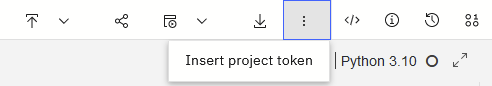

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below. It should look like the following cell:

In [4]:
#dd-ignore
# @hidden_cell
# from project_lib import Project
# project = Project(project_id='your-project-id', project_access_token='your-access-token')

## Data Preparation
<b>Please take some time to read the `Data_Manipulation` notebook, to get familiar with the data sets and run through the sanity checks for all the tables. </b>

### Data Input
Let us first load the data sets from the scenario.

In [5]:
#dd-ignore

!pip install --user dd-scenario

  Preparing metadata (setup.py) ... done
  Created wheel for dd-scenario: filename=dd_scenario-0.9.1-py3-none-any.whl size=33646 sha256=287d16bf4bc83ebee1966f29f467ea1e46c7460d023f56a472d40ac1f69264be
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/f3/d7/9f/7d6884b70fbe8b7bd6ed2d72ffb941b82b422f1a4a126df0a4
Successfully built dd-scenario


In [6]:
#dd-ignore

from dd_scenario import *

pc = project.project_context
# Creates a client...
# If you want to be able to call solve() on the client, you have to provide your API Key
# client = Client(pc=pc, apikey='IAM_APIKEY')
client = Client(pc=pc)

In [7]:
#dd-ignore

#Get 'sales_production_planning' decision...
dd_model_builder = client.get_model_builder(name="sales_production_planning")

#Get scenario 'Baseline XC'...
scenario = dd_model_builder.get_scenario(name="Baseline")

#Load all input data as a map { data_name: data_frame }
inputs = scenario.get_tables_data(category='input')
# This will hold all outputs as a map { data_name: data_frame }
outputs = {}

Now we need to unify the column names and set indexes of the dataframes.

In [8]:
month = inputs["Months"].rename(columns={"name":"month"}).set_index(["month"], verify_integrity=True)
product = inputs["Products"].rename(columns={"name":"product"}).set_index(["product"], verify_integrity=True)
plant_month_capacity = inputs["PlantMonthCapacities"].rename(columns={"value":"plant_month_capacity"}).set_index(["plant", "month"], verify_integrity=True)
plant_product_month_capacity = inputs["PlantProductMonthCapacities"].rename(columns={"value":"plant_product_month_capacity"}).set_index(["plant", "product", "month"], verify_integrity=True)
plant_product_cost = inputs["PlantProductCosts"].rename(columns={"value":"plant_product_cost"}).set_index(["plant", "product"], verify_integrity=True)
market = inputs["Markets"].rename(columns={"name":"market"}).set_index(["market"], verify_integrity=True)
initial_inventory = inputs["InitialInventories"].rename(columns={"value":"initial_inventory"}).set_index(["product", "market"], verify_integrity=True)
transportation_cost = inputs["Transportation"].rename(columns={"name":"market", "value":"transportation_cost"}).set_index(["plant", "product", "market"], verify_integrity=True)
demand = inputs["Demands"].rename(columns={"value":"demand"}).set_index(["product", "market", "month"], verify_integrity=True)
firm_sales = inputs["FirmSales"].rename(columns={"value":"firm_sales"}).set_index(["product", "market", "month"], verify_integrity=True)
sales_price = inputs["SalesPrice"].rename(columns={"value":"sales_price"}).set_index(["product", "market", "month"], verify_integrity=True)

## Pre-processing
The following tables help us to create decision variables.

In [9]:
market_overview = demand.merge(sales_price, how='left', left_index=True, right_index=True).merge(firm_sales, how='left', left_index=True, right_index=True).fillna(0)
market_overview.head(3)

demand  sales_price  firm_sales
product    market month                                  
Bandit 900 Spain  Jun-08      62          672         0.0
                  Jul-08      55          640         0.0
                  Aug-08      56          631         0.0

Create a data set for starting and ending inventory.

In [10]:
product_idx = product.index
market_idx = market.index
month_idx = month.index
idx = pd.MultiIndex.from_product([product_idx, market_idx, month_idx], names=['product', 'market', 'month'])
inventory = pd.DataFrame(index=idx)
inventory.head(3)

Empty DataFrame
Columns: []
Index: [(CRS550, US, Jan-07), (CRS550, US, Feb-07), (CRS550, US, Mar-07)]

Enrich the transportation cost table with a time axis.

In [11]:
idx = plant_product_month_capacity.index
transportation = pd.DataFrame(index=idx).reset_index()
transportation = pd.concat([transportation]*len(market_idx))
transportation["market"] = market_idx.values.repeat(len(plant_product_month_capacity))
#transportation = transportation.set_index(["plant", "product", "market", "month"]).merge(transportation_cost, left_index=True, right_index=True, how="left").drop(columns=["region"])
transportation = transportation.merge(transportation_cost.reset_index(), how="left", on=["plant", "product", "market"]).drop(columns=["region"]).set_index(["plant", "product", "market", "month"])
transportation.head(3)

transportation_cost
plant    product market month                      
Bucarest 200S    US     Apr-07                   42
                        Apr-08                   42
                        Aug-07                   42

Some additional information

In [12]:
firstmonthName = month[month["id"]==min(month["id"])].index.values[0]
lastmonthName = month[month["id"]==max(month["id"])].index.values[0]

Add the production cost to the plant$*$product$*$month capacity table.

In [13]:
#plant_product_month_capacity = plant_product_month_capacity.merge(plant_product_cost, how="left", left_index=True, right_index=True)
plant_product_month_capacity = plant_product_month_capacity.reset_index().merge(plant_product_cost.reset_index(), how="left", on=["plant","product"]).set_index(["plant","product","month"])
plant_product_month_capacity.head(3)

plant_product_month_capacity  plant_product_cost
plant    product month                                                   
Bucarest 200S    Apr-07                           210               106.0
                 Apr-08                           210               106.0
                 Aug-07                           210               106.0

<a id = "decision-variables"></a>
## Decision variables

In [14]:
from docplex.mp.model import Model
mdl = Model(name='sales_and_operation_planning', log_output=True)

### Production Plan
We first define the variables, which represent the production in every plant on a monthly level.

In [15]:
plant_product_month_capacity["Production"] = pd.Series(
    mdl.integer_var_list(plant_product_month_capacity.index, lb=0, ub=plant_product_month_capacity.plant_product_month_capacity, name="Production"), 
    index=plant_product_month_capacity.index)
plant_product_month_capacity.head(3)

plant_product_month_capacity  plant_product_cost  \
plant    product month                                                      
Bucarest 200S    Apr-07                           210               106.0   
                 Apr-08                           210               106.0   
                 Aug-07                           210               106.0   

                                              Production  
plant    product month                                    
Bucarest 200S    Apr-07  Production_Bucarest_200S_Apr-07  
                 Apr-08  Production_Bucarest_200S_Apr-08  
                 Aug-07  Production_Bucarest_200S_Aug-07

### Product Allocation
After a product is being produced, it will be allocated to a specific market, based on the month and the market. This is reflected on the following variable, `Allocation`. 

In [16]:
transportation["Allocation"] = pd.Series(
    mdl.integer_var_list(transportation.index, lb=0, name="Allocation"), index=transportation.index)
transportation.head(3)

transportation_cost  \
plant    product market month                         
Bucarest 200S    US     Apr-07                   42   
                        Apr-08                   42   
                        Aug-07                   42   

                                                        Allocation  
plant    product market month                                       
Bucarest 200S    US     Apr-07  Allocation_Bucarest_200S_US_Apr-07  
                        Apr-08  Allocation_Bucarest_200S_US_Apr-08  
                        Aug-07  Allocation_Bucarest_200S_US_Aug-07

### Sales
As the name `ExecutedSales` implies, this variable expresses the sales amount in a specific market in a month. 

In [17]:
market_overview["ExecutedSales"] = pd.Series(
    mdl.integer_var_list(market_overview.index, lb=market_overview.firm_sales, ub=market_overview.demand, name="ExecutedSales"), index=market_overview.index)
market_overview.head(3)

demand  sales_price  firm_sales  \
product    market month                                     
Bandit 900 Spain  Jun-08      62          672         0.0   
                  Jul-08      55          640         0.0   
                  Aug-08      56          631         0.0   

                                                  ExecutedSales  
product    market month                                          
Bandit 900 Spain  Jun-08  ExecutedSales_Bandit 900_Spain_Jun-08  
                  Jul-08  ExecutedSales_Bandit 900_Spain_Jul-08  
                  Aug-08  ExecutedSales_Bandit 900_Spain_Aug-08

### Inventory
`StartingInventory` defines the starting inventory of every product on the market and month-start level, whereas `EndingInventory` marks the inventory for the end of the month. Note that the latter variable is defined only for result analysis purposes. 

In [18]:
inventory["StartingInventory"] = pd.Series(
    mdl.integer_var_list(inventory.index, lb=0, name="StartingInventory"), index=inventory.index)
#inventory["EndingInventory"] = inventory.groupby(["product", "market"])["StartingInventory"].shift(-1, fill_value=0)
inventory["EndingInventory"] = inventory.groupby(["product", "market"])["StartingInventory"].shift(-1).fillna(0)
inventory.head(3)

StartingInventory  \
product market month                                        
CRS550  US     Jan-07  StartingInventory_CRS550_US_Jan-07   
               Feb-07  StartingInventory_CRS550_US_Feb-07   
               Mar-07  StartingInventory_CRS550_US_Mar-07   

                                          EndingInventory  
product market month                                       
CRS550  US     Jan-07  StartingInventory_CRS550_US_Feb-07  
               Feb-07  StartingInventory_CRS550_US_Mar-07  
               Mar-07  StartingInventory_CRS550_US_Apr-07

## Constraints

### Inject the initial inventory to the decision variable inventory

In [19]:
for pr, mr in initial_inventory.index.values:
    inventory_first = inventory.at[(pr,mr,firstmonthName), "StartingInventory"]
    mdl.add_constraint(inventory_first == initial_inventory.at[(pr,mr), "initial_inventory"], ctname="inventory_initialization_{}_{}".format(pr,mr))

### The total amount of production per month is limited by the capacity of the plant

In [20]:
for pl_mn, group in plant_product_month_capacity.groupby(["plant", "month"]):
    month_capacity = plant_month_capacity.at[pl_mn,"plant_month_capacity"]
    mdl.add_constraint(mdl.sum(group.Production) <= month_capacity, ctname="monthly_totalproduction_capacity_{}".format(pl_mn))

### Plants cannot produce more than their product-based capacity
This constraint is already included in the definition of the decision variable `Production` as the upper bound. 

### Production equals Allocation

In [21]:
for pl_pr_mn, group in transportation.groupby(["plant", "product", "month"]):
    production = plant_product_month_capacity.at[pl_pr_mn, "Production"]
    mdl.add_constraint(mdl.sum(group.Allocation) == production, ctname="monthly_production_alignment_{}".format(pl_pr_mn))

### Executed sales are at least the firm sales
This constraint is also included in the definition of the decision variable `ExecutedSales` as the lower bound.

### Executed sales are at most the planned demand
Demand is apparently the upper bound in the definition of `ExecutedSales`.

### Starting Inventory + Allocation = Executed Sales + Ending Inventory

In [22]:
for pr, mr, mn in inventory.index.values:
    inventory_current = inventory.loc[(pr,mr,mn)]
    mdl.add_constraint(
        inventory_current.StartingInventory + 
        #mdl.sum(transportation.query("product==@pr & market==@mr & month==@mn").Allocation) 
        mdl.sum(transportation.loc[pd.IndexSlice[:,pr,mr,mn], "Allocation"])==
        mdl.sum(market_overview.at[(pr2, mr2, mn2),"ExecutedSales"] for (pr2, mr2, mn2) in market_overview.index.values if pr2==pr and mr2==mr and mn2==mn) +
        inventory_current.EndingInventory, ctname="balancing_{}_{}_{}".format(pr, mr, mn))

### Ending Inventory = Starting Inventory of the previous month (no inventory at the end of last month)
This constraint is considered in the definition of the column `EndingInventory`. In other words, we just created this column, but with the decision variable `StartingInventory`, by taking advantage of this formulation.

## KPIs and Objectives
There are three KPIs we would like to consider in this simplified business case, the production cost, transporation cost as well as the revenue.

In [23]:
production_cost_kpi = mdl.sum(plant_product_month_capacity.Production*plant_product_month_capacity.plant_product_cost)
mdl.add_kpi(production_cost_kpi, "Total_production_cost")

transportation_cost_kpi = mdl.sum(transportation.Allocation*transportation.transportation_cost)
mdl.add_kpi(transportation_cost_kpi, "Total_transportation_cost")

revenue_kpi = mdl.sum(market_overview.sales_price*market_overview.ExecutedSales)
mdl.add_kpi(revenue_kpi, "Revenue")

mdl.maximize(revenue_kpi - transportation_cost_kpi - production_cost_kpi)

## Model Solving
- The log_output shows cplex log
- Always add a timelimit in case of unexpected very long solves

In [24]:
msol = mdl.solve(log_output=True, cplex_parameters = {'timelimit':60})
if msol is not None:
    mdl.report()

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
CPXPARAM_TimeLimit                               60
Tried aggregator 2 times.
MIP Presolve eliminated 319 rows and 326 columns.
Aggregator did 7 substitutions.
Reduced MIP has 12688 rows, 73436 columns, and 139222 nonzeros.
Reduced MIP has 14 binaries, 73422 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.21 sec. (82.30 ticks)
Found incumbent of value 7901062.000000 after 0.65 sec. (260.19 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 12688 rows, 73436 columns, and 139222 nonzeros.
Reduced MIP has 14 binaries, 73422 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.17 sec. (78.46 ticks)
Probing time = 0.01 sec. (1.05 ticks)
Clique table members: 1.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxati

## Solution Handling
Now let us save the solution values in the dictionary `outputs`, which then could be used in the scenario to generate some visualizations for model understanding.

In [25]:
plant_product_month_capacity["production"] = [production.solution_value for production in plant_product_month_capacity.Production]
production_output = plant_product_month_capacity.reset_index().drop(columns=["Production","plant_product_cost", "plant_product_month_capacity","product","plant"]).groupby(["month"]).sum().reset_index()
plant_capacity = plant_month_capacity.groupby(["month"]).sum().reset_index()
production_output = production_output.merge(plant_capacity, on=["month"], how="left")
production_output["utilization"] = production_output.production/production_output.plant_month_capacity
production_output["month"] = pd.to_datetime(production_output["month"], format='%b-%y')
production_output.head()

month  production  plant_month_capacity  utilization
0 2007-04-01     15021.0                 15021          1.0
1 2008-04-01     14934.0                 14934          1.0
2 2007-08-01     14457.0                 14457          1.0
3 2008-08-01     15849.0                 15849          1.0
4 2007-12-01     13413.0                 13413          1.0

In [26]:
market_overview["executedsales"] = [executedsales.solution_value for executedsales in market_overview.ExecutedSales]
executedsales_output = market_overview.drop(columns=["ExecutedSales","firm_sales","sales_price"]).groupby(["month"]).sum().reset_index()
executedsales_output["month"] = pd.to_datetime(executedsales_output["month"], format="%b-%y")
executedsales_output["satisfied_demand"] = executedsales_output.executedsales/executedsales_output.demand
executedsales_output.head()

month  demand  executedsales  satisfied_demand
0 2007-04-01   20077        13769.0          0.685810
1 2008-04-01   22926        16830.0          0.734101
2 2007-08-01   19617        13923.0          0.709742
3 2008-08-01   22138        17148.0          0.774596
4 2007-12-01   20329        14452.0          0.710906

In [27]:
outputs['production_output'] = production_output
outputs['executedsales_output'] = executedsales_output

Now let us save all the outputs in an excel file for further analysis. Besides, the model itself will also be saved in a lp file. 

Let us verify the constraints by picking one from each type to make sure that they are fulfilled in the model.
- Starting Inventory + Allocation = Executed Sales + Ending Inventory
- Production equals Allocation
- Firm Sales <= Executed Sales <= Demand

In [28]:
#dd-ignore
transportation["allocation"] = [allocation.solution_value for allocation in transportation.Allocation]
inventory["startinginventory"] = [inventory.solution_value for inventory in inventory.StartingInventory]
inventory["endinginventory"] = inventory.groupby(["product", "market"])["startinginventory"].shift(-1).fillna(0)

df = inventory.merge(transportation.groupby(["product","market","month"]).sum(numeric_only=True), left_index=True, right_index=True).merge(market_overview["executedsales"], left_index=True, right_index=True).fillna(0)
df_1 = df[df.startinginventory + df.allocation != df.executedsales + df.endinginventory]

df = plant_product_month_capacity.merge(transportation.groupby(["plant","product","month"]).sum(numeric_only=True), left_index=True, right_index=True)
df_2 = df[df.production != df.allocation]

df_3 = market_overview[(market_overview.executedsales > market_overview.demand) | (market_overview.executedsales < market_overview.firm_sales)]

display_side_by_side([df_1, df_2, df_3], ["Violation of constraint 1", "Violation of constraint 2", "Violation of constraint 3"])

## Solution Review
<b>Having created a DO model, now we could start analyzing the solution and create different what-if scenarios to address uncertainties in the supply chain. </b> 

### Authors
-  __Qiannan Gao__ is a Data Scientist of the IBM Data Science & AI Elite Team.
-  __Eray Cakici__ is an Operations Research Scientist of the IBM Data Science & AI Elite Team.


### License
 Copyright © IBM Corp. 2020-2024. Released as licensed Sample Materials.